# **Day 기준으로 모델링**

In [1]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet.plot import add_changepoints_to_plot

# pandas max row 
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

In [6]:
data = pd.read_csv('total_eng.csv', encoding='cp949')

In [7]:
data = data[9:27025] #drop unknwon period(~2017060108, 2020070100~ )
data = data.reset_index(drop = True)
data.columns = ['datetime','solar_result','temp','rain_t','rain_r',
                    'hum','wins', 'wind','sky','altitude','azimuth']
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d%H')

In [8]:
data['day'] = data['datetime'].apply(lambda x : x.strftime('%Y%m%d'))
data['day'] = pd.to_datetime(data['day'], format = '%Y%m%d')
data = data.groupby('day').agg({'solar_result' : 'sum'})
data.head()

,solar_result
day,
2017-06-01,725.52
2017-06-02,1019.28
2017-06-03,997.20
2017-06-04,1019.04
2017-06-05,1001.28


### **정규화**

In [9]:
mean = data.loc[:'2019-05-31','solar_result'].mean()
std = data.loc[:'2019-05-31','solar_result'].std()
data['solar_reuslt_sc'] = data['solar_result'].apply(lambda x : (x-mean)/std)

Prophet 모델에 맞춰 column 명 변경(ds, y 컬럼이 반드시 필요)
- day -> ds
- solar_result_sc  -> y

In [12]:
data['y'] = data['solar_reuslt_sc']
data['ds'] = data.index

data.head()

,solar_result,solar_reuslt_sc,y,ds
day,,,,
2017-06-01,725.52,0.152559,0.152559,2017-06-01
2017-06-02,1019.28,1.175753,1.175753,2017-06-02
2017-06-03,997.20,1.098847,1.098847,2017-06-03
2017-06-04,1019.04,1.174917,1.174917,2017-06-04
2017-06-05,1001.28,1.113058,1.113058,2017-06-05


Train, test set 분리
(2019-06-01 기준)

In [13]:
train = data[data['ds'] < '2019-06-01']
test = data[data['ds'] >= '2019-06-01']

In [20]:
train.head()

,solar_result,solar_reuslt_sc,y,ds
day,,,,
2017-06-01,725.52,0.152559,0.152559,2017-06-01
2017-06-02,1019.28,1.175753,1.175753,2017-06-02
2017-06-03,997.20,1.098847,1.098847,2017-06-03
2017-06-04,1019.04,1.174917,1.174917,2017-06-04
2017-06-05,1001.28,1.113058,1.113058,2017-06-05


In [21]:
test.head()

,solar_result,solar_reuslt_sc,y,ds
day,,,,
2019-06-01,959.52,0.967603,0.967603,2019-06-01
2019-06-02,945.84,0.919955,0.919955,2019-06-02
2019-06-03,1052.64,1.291950,1.291950,2019-06-03
2019-06-04,1022.64,1.187457,1.187457,2019-06-04
2019-06-05,1030.56,1.215043,1.215043,2019-06-05


### **Prophet 모델 객체 생성**

In [30]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=400)  # 400일 예측
forecast = m.predict(future)
forecast.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1125,2020-06-30,0.122090,-1.162843,1.461625,0.121732,0.122479,-0.020281,-0.020281,-0.020281,-0.020281,-0.020281,-0.020281,0.0,0.0,0.0,0.101809
1126,2020-07-01,0.122249,-1.075276,1.377760,0.121890,0.122640,-0.033947,-0.033947,-0.033947,-0.033947,-0.033947,-0.033947,0.0,0.0,0.0,0.088303
1127,2020-07-02,0.122409,-1.271040,1.416304,0.122048,0.122801,0.016506,0.016506,0.016506,0.016506,0.016506,0.016506,0.0,0.0,0.0,0.138916
1128,2020-07-03,0.122569,-1.225750,1.337649,0.122207,0.122963,0.030861,0.030861,0.030861,0.030861,0.030861,0.030861,0.0,0.0,0.0,0.153430
1129,2020-07-04,0.122729,-0.983734,1.421127,0.122365,0.123124,0.065636,0.065636,0.065636,0.065636,0.065636,0.065636,0.0,0.0,0.0,0.188365


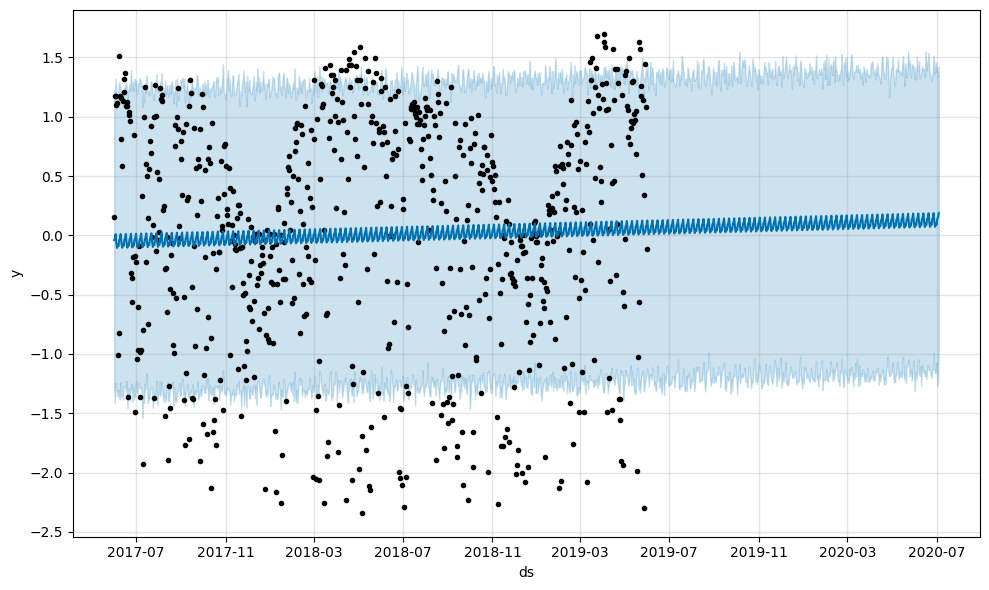

In [31]:
fig1 = m.plot(forecast)

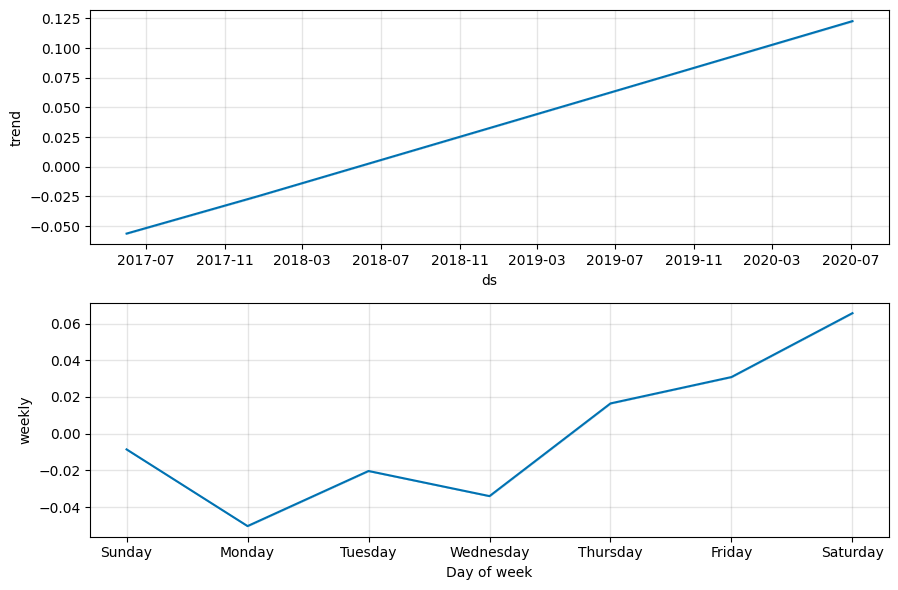

In [32]:
fig = m.plot_components(forecast)

### **실측값과 예측값 비교**

In [33]:
forecast_sub = forecast[['ds', 'yhat']]
forecast_sub['ds'] = forecast_sub['ds']
test_sub = test[['ds', 'y']]
eval_df = test_sub.merge(forecast_sub, on=['ds'], how='left')
eval_df['abs_error'] = abs(eval_df['y']-eval_df['yhat'])
eval_df['daily_FA'] = 1-(eval_df['abs_error']/eval_df['y'])


eval_df['y'] = eval_df['y'].apply(lambda x : x*std+mean) 
eval_df['yhat'] = eval_df['yhat'].apply(lambda x : x*std+mean) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [34]:
eval_df.head(10)

,ds,y,yhat,abs_error,daily_FA
0,2019-06-01,959.52,717.501793,0.842973,0.128803
1,2019-06-02,945.84,696.258159,0.869318,0.055043
2,2019-06-03,1052.64,684.319653,1.282896,0.007008
3,2019-06-04,1022.64,692.972508,1.148264,0.033005
4,2019-06-05,1030.56,689.094870,1.189356,0.021140
5,2019-06-06,804.96,703.625828,0.352957,0.177747
6,2019-06-07,139.44,707.792830,1.979629,2.048079
7,2019-06-08,870.96,717.822816,0.533392,0.190777
8,2019-06-09,913.20,696.579182,0.754512,0.064191
9,2019-06-10,784.08,684.640676,0.346357,0.028530


### **시각화(실측값 VS. 예측값)**

In [35]:
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100

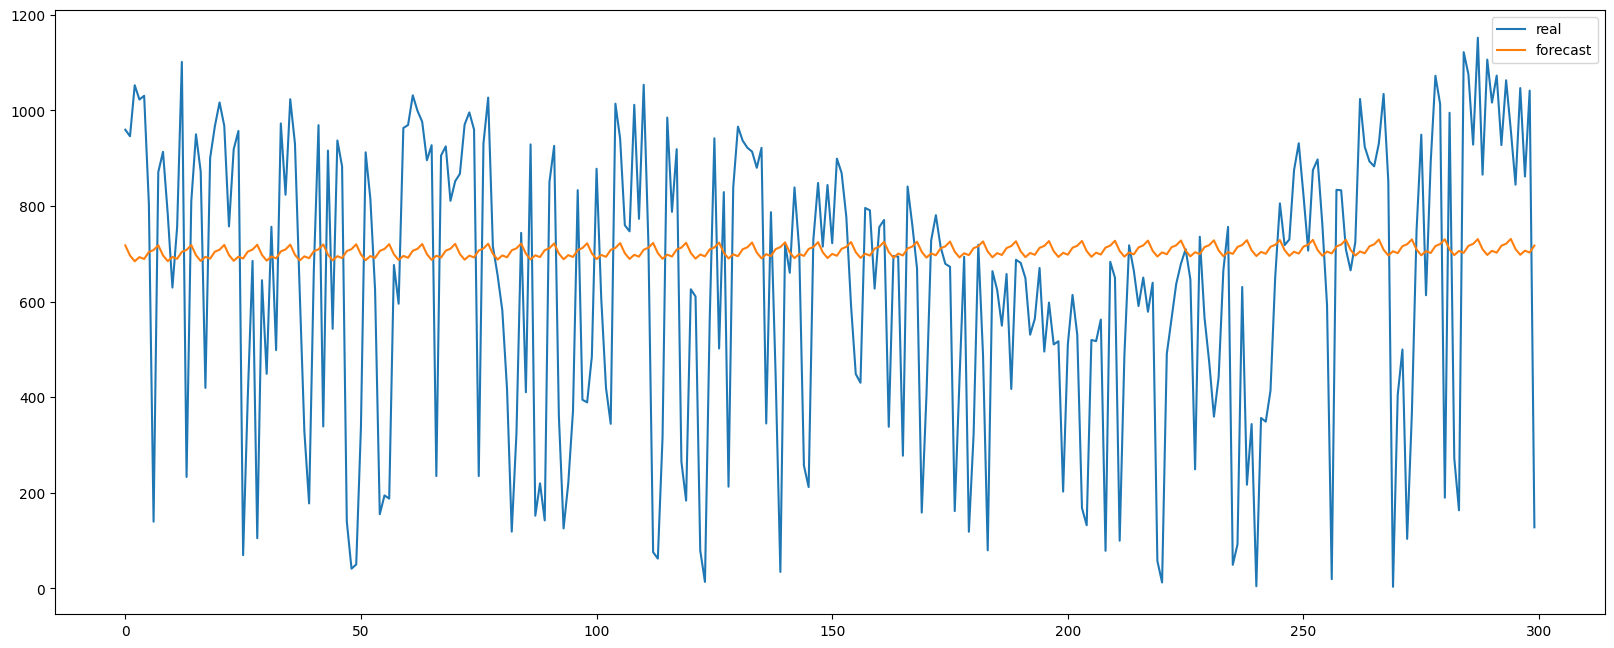

In [36]:
plt.plot(eval_df['y'][:300], label = 'real')
plt.plot(eval_df['yhat'][:300], label ='forecast')
plt.legend()
plt.show()